Feature engineering cumulative impact
================================
*A companion notebook of R code to the articles:*

* [Part I](TBD)

In [7]:
library(dplyr)
library(splines)
library(ggplot2)

## Movitating Articles

[Fatigue and fitness modelled from the effects of training on performance](https://www.researchgate.net/profile/Robin_Candau/publication/15242395_Fatigue_and_fitness_modelled_from_the_effects_of_training_on_performance/links/55720f2608ae7536374cdc09/Fatigue-and-fitness-modelled-from-the-effects-of-training-on-performance.pdf) (Busso, Candau, and Lacour 1994, referred to as "BCL94" in the companion article

[Modeling human performance in running](https://www.researchgate.net/publication/20910238_Modeling_human_performance_in_running) (Morton, Clarke and Banister 1990)

[Convolution notes from MIT's Jeremy Orloff](https://math.mit.edu/~jorloff/suppnotes/suppnotes03/i.pdf)


Average training intensity during build up phase: 34.14 
Average training intensity during competition phase: 23.98

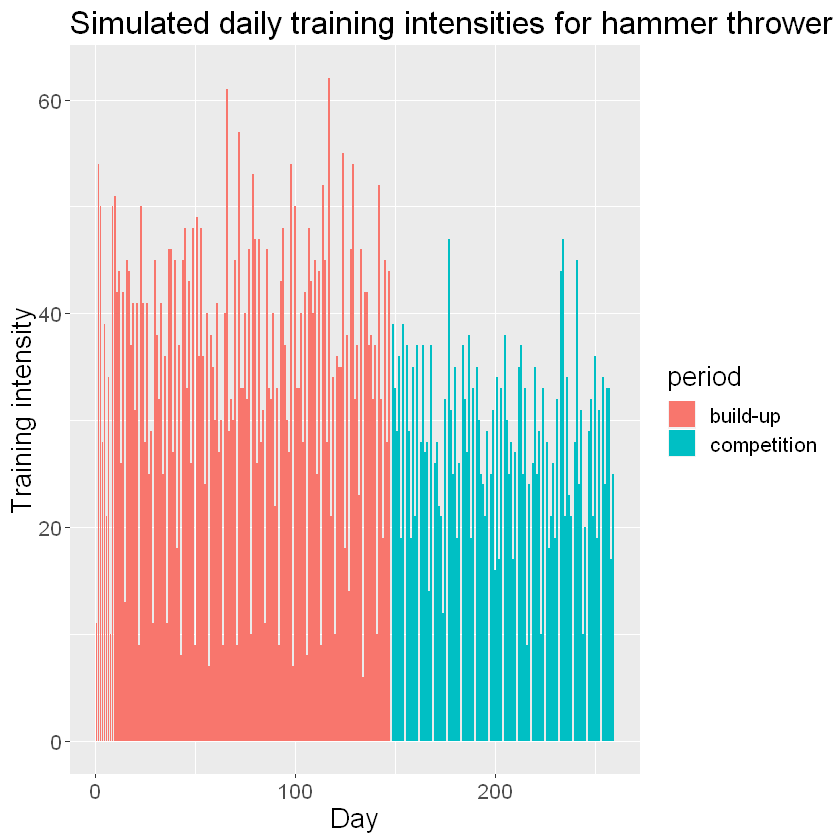

In [26]:
train_df <- data.frame(day = 1:259, day_of_week = 0:258 %% 7)
train_df$period <- ifelse(train_df$day <= 147, "build-up", "competition")
train_df$w <- with(train_df, w <-
  -24 * (day_of_week == 0) +
   12 * (day_of_week == 1) +
    8 * (day_of_week == 2) +
    0 * (day_of_week == 3) +
    6 * (day_of_week == 4) +
   -8 * (day_of_week == 5) +
    6 * (day_of_week == 6))

train_df$w <- rpois(nrow(train_df),
                    train_df$w + ifelse(train_df$period == "build-up", 34, 24))

cat("Average training intensity during build up phase:",
    round(mean(train_df$w[train_df$day <= 147]), 2), "\n")
cat("Average training intensity during competition phase:",
    round(mean(train_df$w[train_df$day > 147]), 2))

ggplot(train_df, aes(x = day, y = w)) +
  geom_bar(aes(fill = period), stat = "identity") +
  ggtitle("Simulated daily training intensities for hammer thrower") +
  xlab("Day") + ylab("Training intensity") +
  theme(text = element_text(size = 16))


Fitness and Fatigue follow Exponential Decay: $g(t) = k \exp(-t / τ)$

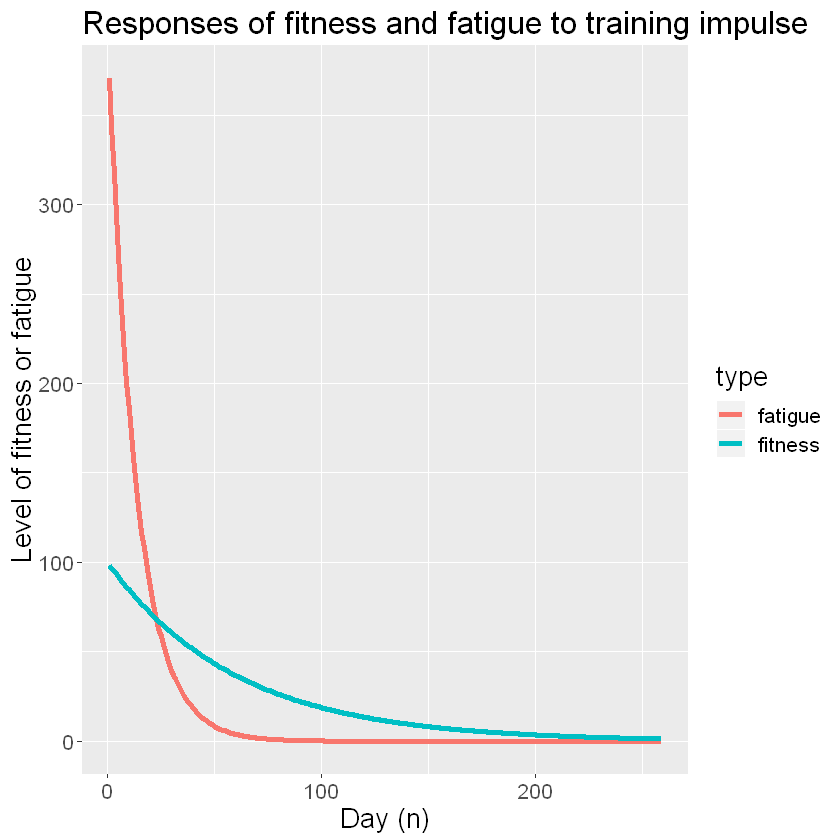

In [9]:
# Exponential decay and fitness-fatigue profiles
exp_decay <- function(t, tau) {
  exp(-t / tau)
}

grid_df <- rbind(data.frame(day = 1:259, level = 400 * exp_decay(1:259, 13),
                            type = "fatigue"),
                 data.frame(day = 1:259, level = 100 * exp_decay(1:259, 60),
                            type = "fitness"))

ggplot(grid_df, aes(x = day, y = level)) +
  geom_line(aes(color = type), size = 1.5) +
  ggtitle("Responses of fitness and fatigue to training impulse") +
  xlab("Day (n)") + ylab("Level of fitness or fatigue") +
  theme(text = element_text(size = 16))


The effect of either fitness or fatigue at a given point in time is expressed as a convolution
of the training history with the relevant decay function:
$$
\sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{\tau} \right)
$$

In [ ]:
convolve_training <- function(training, n, tau) {
  sum(training[1:(n - 1)] * exp_decay((n - 1):1, tau))
}

fitness <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 60))

fatigue <- sapply(1:nrow(train_df),
                  function(n) convolve_training(train_df$w, n, 13))


The final expected performance function for our simulated hammer thrower is:
$$
\text{E}(p_n) = 496 + 0.07 \sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{60} \right) - 0.27 \sum_{i=1}^{n-1} w_i \exp \left(\frac{-(n-i)}{13} \right) 
$$

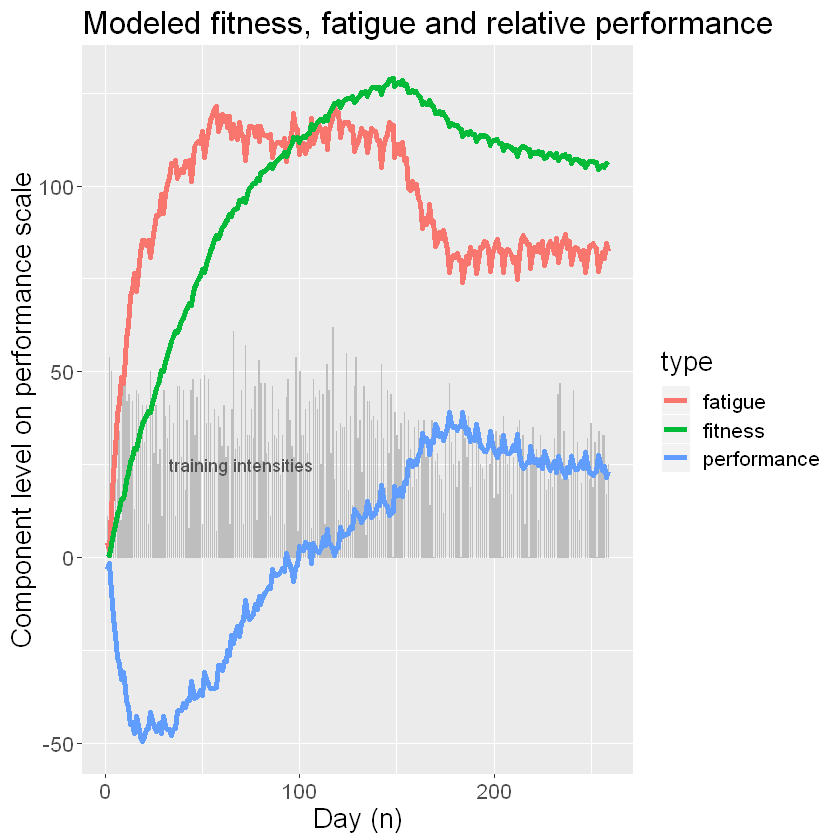

In [29]:
E_perf <- 496 + .07 * fitness - .27 * fatigue

set.seed(45345)
train_df$perf <- E_perf + 7.0 * rnorm(nrow(train_df))

components_df <- rbind(
  data.frame(level = .27 * fatigue, day = train_df$day, type = "fatigue"),
  data.frame(level = .07 *fitness, day = train_df$day, type = "fitness"),
  data.frame(level = E_perf - 496, day = train_df$day, type = "performance"))

ggplot(components_df, aes(x = day, y = level)) +
  geom_col(data = train_df, aes(x = day, y = w), color = "grey", width = .2) +
  geom_line(aes(color = type), size = 1.5) +
  annotate("text", label = "training intensities", x = 70, y = 25,
           color = "grey32") +
  ggtitle("Modeled fitness, fatigue and relative performance") +
  xlab("Day (n)") + ylab("Component level on performance scale") +
  theme(text = element_text(size = 16))

In [39]:
# Recover parameters using non-linear regression
rss <- function(theta) {
  int  <- theta[1] # performance baseline
  k1   <- theta[2] # fitness weight
  k2   <- theta[3] # fatigue weight
  tau1 <- theta[4] # fitness decay
  tau2 <- theta[5] # fatigue decay

  fitness <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau1))

  fatigue <- sapply(1:nrow(train_df),
                    function(n) convolve_training(train_df$w, n, tau2))

  perf_hat <- int + k1 * fitness - k2 * fatigue
  return(sum((train_df$perf - perf_hat) ^ 2))
}


optim_results <- optim(c(400, .05, .15, 20, 5), rss, method = "BFGS",
                       hessian = TRUE, control = list(maxit = 1000))
                    
print(optim_results$convergence) # 0 means algorithm as converged

[1] 0


In [40]:
VarCov <- solve(optim_results$hessian)
parm_names <- c("baseline", "fitness weight", "fatigue weight",
                "fitness time const", "fatigue time const")
for (i in 1:5) {
  cat(parm_names[i], "estimate:", round(optim_results$par[i], 2),
      ", std.err.:", round(sqrt(diag(VarCov))[i], 2), "\n")
}

baseline estimate: 490.17 , std.err.: 0.31 
fitness weight estimate: 0.15 , std.err.: 0.01 
fatigue weight estimate: 0.29 , std.err.: 0.01 
fitness time const estimate: 45.41 , std.err.: 0.69 
fatigue time const estimate: 21.24 , std.err.: 0.38 


[1] "par"         "value"       "counts"      "convergence" "message"    
[6] "hessian"